In [23]:
# run in base
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gpytorch

from utils import make_grid
from configs import N_SIDE_INFERENCE

from scipy.interpolate import griddata
from real_preprocess import load_and_preprocess_ice_velocity_data

# Translate prediction sample back

Sample 1 for region_lower_byrd ice thickness:


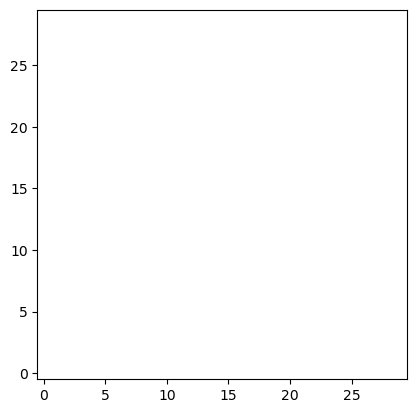

Sample 2 for region_lower_byrd ice thickness:


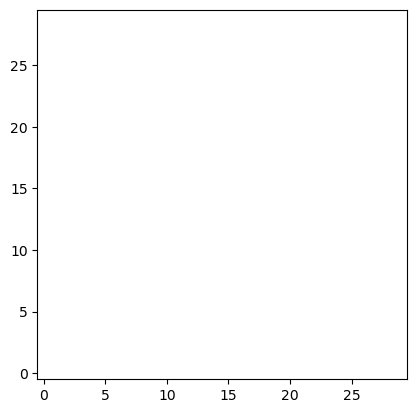

Sample 1 for region_mid_byrd ice thickness:


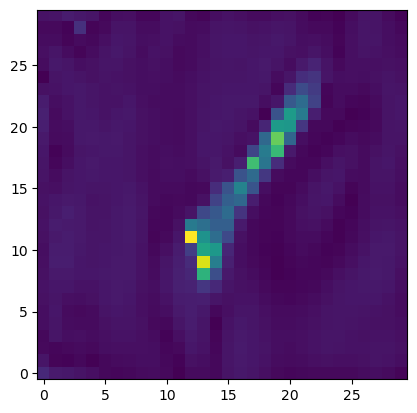

Sample 2 for region_mid_byrd ice thickness:


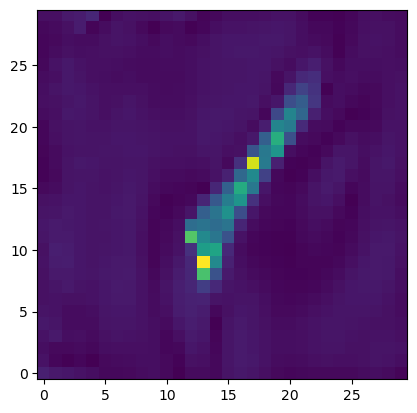

Sample 1 for region_upper_byrd ice thickness:


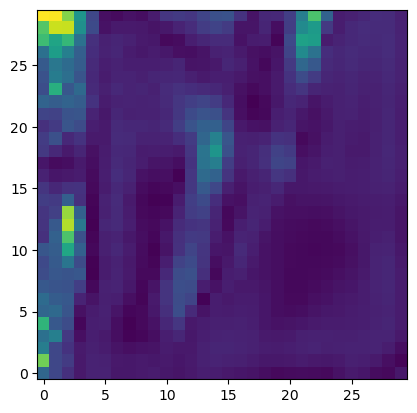

Sample 2 for region_upper_byrd ice thickness:


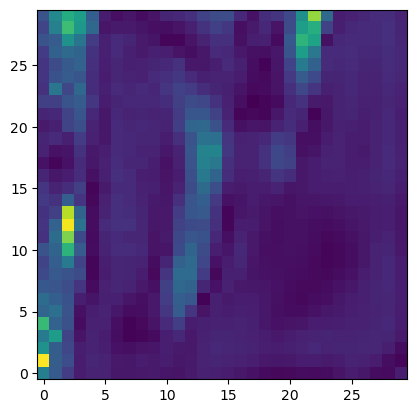

In [40]:
N_SAMPLES = 2
export_path = "figures_real/dfNGP_ice_thickness/"

# LOOP OVER REGIONS
for region in ["region_lower_byrd", "region_mid_byrd", "region_upper_byrd"]:

    # STEP 1: load data
    folder_path = "results_real/dfNGP/"
    mean_file_path = folder_path + region + "_dfNGP_grid_mean_predictions.pt"
    covar_file_path = folder_path + region + "_dfNGP_grid_covar_predictions.pt"
    # latent_covar_file_path = folder_path + region + "_dfNGP_grid_latent_covar_predictions.pt"

    mean = torch.load(mean_file_path, weights_only = False)
    covar = torch.load(covar_file_path, weights_only = False)
    # latent_covar = torch.load(latent_covar_file_path, weights_only = False)

    # STEP 2: Put back into MultitaskMultivariateNormal format
    posterior = gpytorch.distributions.MultitaskMultivariateNormal(mean, covar)
    # posterior = gpytorch.distributions.MultitaskMultivariateNormal(mean, latent_covar)

    # STEP 3: Prep region scaling specs
    region_specs = pd.read_csv("data/real_data/corners_byrd_regions.csv")
    flux_scalar = region_specs.loc[region_specs["name"] == region, "flux_scalar"].values[0]

    # STEP 4: Scale x_grid back to polar stereographic coordinates
    _, x_grid = make_grid(N_SIDE_INFERENCE)

    x_min = region_specs.loc[region_specs["name"] == region, "x_min"].values[0]
    x_max = region_specs.loc[region_specs["name"] == region, "x_max"].values[0]

    x1_ps = x_grid[:, 0] * (x_max - x_min) + x_min

    y_min = region_specs.loc[region_specs["name"] == region, "y_min"].values[0]
    y_max = region_specs.loc[region_specs["name"] == region, "y_max"].values[0]

    x2_ps = x_grid[:, 1] * (y_max - y_min) + y_min

    x_grid_ps = torch.cat((x1_ps.unsqueeze(1), x2_ps.unsqueeze(1)), dim = 1)
    x_grid_ps_df = pd.DataFrame(x_grid_ps.numpy(), columns = ["x", "y"])

    # Step 5: Interpolate ice velocity 

    ice_vel_file_path = '/home/kim/data/nsidc/antarctica_ice_velocity_450m_v2.nc'
    # Function to load and preprocess the ice velocity data as xarray

    velocity_grid = load_and_preprocess_ice_velocity_data(ice_vel_file_path)
    # Subset vars for faster interpolation
    velocity_grid = velocity_grid[["VX", "VY"]]

    velocity_grid_interpolated = velocity_grid.interp(
            y = (x_grid_ps_df["y"]), 
            x = (x_grid_ps_df["x"]), 
            method = "cubic") # smooth interpolation

    # Interpolates for combinations of points so we only need diagonal
    VX_diag = np.diag(velocity_grid_interpolated.VX.values)
    VY_diag = np.diag(velocity_grid_interpolated.VY.values)

    # Step 6: Calculate velocity magnitude
    velocity_magnitude = np.sqrt(VX_diag**2 + VY_diag**2)
    
    # STEP 7: Sample from posterior, scale, calculate ic thickness, export
    for i in range(N_SAMPLES):
        # Sample
        sample = posterior.rsample()
        # Scale
        sample_scaled = sample * flux_scalar
        # Magnitude
        sample_magnitude = torch.sqrt(sample_scaled[:, 0]**2 + sample_scaled[:, 1]**2)
        # Ice thickness t = |flux| / |v|
        sample_thickness = sample_magnitude.detach().cpu().numpy() / velocity_magnitude
        # Reshape
        sample_thickness_field = sample_thickness.reshape((N_SIDE_INFERENCE, N_SIDE_INFERENCE))
        # Export
        torch.save(torch.tensor(sample_thickness_field), export_path + region + "_dfNGP_sample_" + str(i) + "_thickness.csv")
        
        # STEP 8: Visualise
        print(f"Sample {i + 1} for {region} ice thickness:")
        plt.imshow(sample_thickness_field, cmap = 'viridis', origin = 'lower')
        plt.show()